In [1]:
import os
import sys
from datetime import datetime

# Add ../src to the path
proj_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
sys.path.insert(0, proj_path)

# Import the parse config function to parse the .toml file
from utils.config_tool import parse_config
from utils.logging_tool import initialize_logger
from strategy.train_trading_agent import train_trading_agent

# Get the time
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Load the config file
config = parse_config("../config/trade_w_llm.toml")
# Initialize the logger
log_file = "{}_log_{}.txt".format(
			'training_agent',
			str(timestamp))
logger = initialize_logger(log_path=os.path.join(config['info']['local_data_path'], 'logs'),log_file=log_file)

In [2]:
# Import the trading environment
from strategy.engine import trading_env_portfolio
from strategy import train_PPO_agent

In [3]:
from gymnasium.wrappers import FlattenObservation
env = trading_env_portfolio.TradingEnv(config=config, logger=logger)
env = FlattenObservation(env)

/Users/zxmath/Library/Caches/pypoetry/virtualenvs/erdos-finance-llm-OLSUwxnZ-py3.13/lib/python3.13/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/zxmath/Library/Caches/pypoetry/virtualenvs/erdos-finance-llm-OLSUwxnZ-py3.13/lib/python3.13/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [4]:
model = train_PPO_agent.train_PPO_agent(
    env=env,
    config=config,
    logger=logger
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -0.0685  |
| time/              |          |
|    fps             | 1914     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -0.113      |
| time/                   |             |
|    fps                  | 1673        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.028491933 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [5]:
test_start = config["strategy"].get("test_start_date")
test_end   = config["strategy"].get("test_end_date")

In [6]:
logger.info(f"Backtesting on period: {test_start} → {test_end}")
config["strategy"]["train_start_date"] = test_start
config["strategy"]["train_end_date"]   = test_end

In [7]:
   
env = trading_env_portfolio.TradingEnv(config=config, logger=logger)
print(env.data_source.date_length)

env = FlattenObservation(env)

501


/Users/zxmath/Library/Caches/pypoetry/virtualenvs/erdos-finance-llm-OLSUwxnZ-py3.13/lib/python3.13/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/zxmath/Library/Caches/pypoetry/virtualenvs/erdos-finance-llm-OLSUwxnZ-py3.13/lib/python3.13/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [8]:
obs, info = env.reset()
done = False 
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    nav = info.get("nav", env.unwrapped.simulator.navs[env.unwrapped.simulator.step-1])

In [9]:
import matplotlib.pyplot as plt

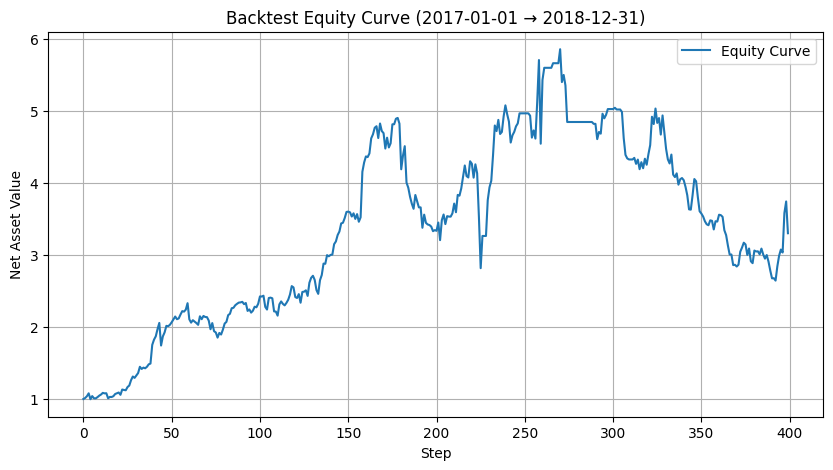

Actions taken during backtest: [array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([3, 4, 1, 3]), array([ 3,  4,  1, 10]), array([3, 4, 1, 3]), array([3, 4, 1, 3]), array([3, 4, 1, 3]), array([3, 4, 1, 3]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  6,  8, 10]), array([10,  7,  7, 10]), array([10,  7

In [10]:
obs, info = env.reset()
done = False

equity_curve = []
actions = []
steps = 0

while not done:
        # Get the action (deterministic for backtest)
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)

        # Step the environment
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

        # Extract NAV from info (or fallback to the simulator’s internal array)
    nav = info.get("nav")
    if nav is None:
        sim = env.unwrapped.simulator
        nav = sim.navs[sim.step - 1]

    equity_curve.append(nav)
    logger.info(f"[Step {steps:03d}] action={action}, reward={reward:.4f}, nav={nav:.4f}")
    steps += 1
    

    # 6) Plot the equity curve
plt.figure(figsize=(10, 5))
plt.plot(equity_curve, label="Equity Curve")
plt.xlabel("Step")
plt.ylabel("Net Asset Value")
plt.title(f"Backtest Equity Curve ({test_start} → {test_end})")
plt.grid(True)
plt.legend()
plt.show()

    # (Optional) Print out the sequence of actions
print("Actions taken during backtest:", actions)